# **ETF Portfolio Optimization**


## **Introduction**

We aim to optimize a portfolio of Exchange-Traded Funds (ETFs) using various financial and sustainability metrics. The primary objectives of this project include maximizing returns, minimizing risk, capturing momentum, emphasizing ESG (Environmental, Social, and Governance) scores, and ensuring diversification through the Herfindahl-Hirschman Index (HH Index).

This notebook details every step, starting with data extraction, metric calculations, normalization, and portfolio optimization. By the end, we will have an optimized portfolio tailored to meet specified investment objectives.


In [23]:
# Importing Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


## **Step 1: Define ETF List and Time Range**

We define the list of ETFs to analyze and the time range for collecting historical data. The selected ETFs represent various sectors, regions, and investment styles to ensure broad diversification.


In [24]:
# Comprehensive list of ETFs
etf_list = [
    "SPY", "IVV", "VOO", "QQQ", "DIA", "IWM", "VTI", "SCHB", "ITOT", "VEA",
    "EFA", "IEFA", "VWO", "EEM", "IEMG", "AGG", "BND", "LQD", "HYG", "JNK",
    "BSV", "BIV", "BLV", "TIP", "VTIP", "MUB", "TLT", "SHY", "GLD", "IAU",
    "SLV", "PPLT", "PALL", "USO", "UNG", "XLE", "XLF", "XLK", "XLY", "XLP",
    "XLI", "XLB", "XLV", "XLU", "XLRE", "VNQ", "IYR", "REM", "SCHH", "VNQI",
    "RWX", "RWO", "VIG", "VYM", "DVY", "SDY", "SCHD", "NOBL", "SPHD", "DGRW",
    "FDVV", "DLN", "EFG", "EFV", "VLUE", "MTUM", "QUAL", "GSLC", "USMV", "SPLV",
    "VTV", "VOE", "VBR", "IJS", "IJR", "IJH", "MDY", "IJJ", "IJT", "IJK",
    "SCZ", "EFAS", "FXE", "UUP", "FXB", "FXF", "FXY", "DBV", "EWJ", "EWW",
    "EWA", "EWC", "EWZ", "EEM", "RSX", "EWY", "THD", "EIDO", "TUR", "URTH"
]

# Predefined estimation of ESG scores, given by generative AI because exact values are not free to access
esg_scores = [80.56, 68.61, 77.02, 79.66, 78.42, 69.72, 81.37, 78.39, 81.15, 75.35,
              74.54, 81.13, 84.09, 81.49, 66.41, 76.59, 72.03, 74.77, 66.5, 69.49,
              69.73, 82.31, 68.99, 68.97, 65.83, 76.62, 66.45, 71.21, 82.28, 66.58,
              70.25, 67.57, 81.05, 78.4, 76.27, 82.92, 75.65, 84.17, 80.01, 65.87,
              79.04, 71.28, 79.65, 81.48, 77.98, 78.81, 73.07, 67.54, 70.38, 83.24,
              72.32, 66.83, 74.05, 65.54, 71.2, 74.48, 75.96, 80.83, 81.62, 71.24,
              75.27, 79.74, 80.01, 80.4, 80.47, 74.24, 80.62, 83.71, 83.27, 81.79,
              73.94, 70.31, 70.79, 81.96, 81.89, 82.81, 78.16, 70.23, 69.79, 67.53,
              71.48, 81.26, 77.37, 76.16, 68.73, 80.72, 80.91, 76.32, 83.49, 80.16,
              75.64, 84.08, 84.29, 82.58, 81.33, 68.29, 66.95, 72.99, 79.35, 73.36]

# Defining the time range for historical data
start_date = "2021-11-23"
end_date = "2024-11-23"


## **Step 2: Initialize Metrics Containers**

We initialize empty lists to store the calculated metrics for each ETF. These metrics include annualized returns, risk, momentum, ESG scores, and HH Index values.


In [25]:
# Initialize containers for metrics
returns = []
risks = []
momentums = []
hh_indices = []


## **Step 3: Extract Data and Compute Metrics**

For each ETF, we fetch historical price data using `yfinance` and compute the following metrics:
- **Return**: Annualized mean of daily returns.
- **Risk**: Annualized variance of daily returns.
- **Momentum**: Ratio of short-term to long-term moving averages.
- **HH Index**: Proxy for diversification, assuming equal allocation.
- **ESG Score**: Predefined placeholder values.


In [26]:
# Loop through each ETF
for etf in etf_list:
    ticker = yf.Ticker(etf)

    try:
        # Fetch historical data
        data = ticker.history(start=start_date, end=end_date)

        # Skip if no data is available
        if data.empty:
            print(f"No data available for {etf}")
            returns.append(np.nan)
            risks.append(np.nan)
            momentums.append(np.nan)
            hh_indices.append(np.nan)
            continue

        # Calculate daily returns
        daily_returns = data['Close'].pct_change().dropna()

        # Calculate annualized return
        annual_return = daily_returns.mean() * 252  # 252 trading days in a year
        returns.append(annual_return)

        # Calculate annualized risk (variance)
        annual_variance = daily_returns.var() * 252
        risks.append(annual_variance)

        # Calculate momentum (short-term vs long-term moving average ratio)
        if len(data) >= 60:  # Ensure there's enough data for the 60-day moving average
            short_term_ma = data['Close'].rolling(window=20).mean().iloc[-1]
            long_term_ma = data['Close'].rolling(window=60).mean().iloc[-1]
            momentum = (short_term_ma / long_term_ma) - 1 if long_term_ma != 0 else np.nan
        else:
            momentum = np.nan
        momentums.append(momentum)

        # Calculate HH Index (placeholder for diversification)
        hh_index = 1 / len(etf_list)  # Divide by the total number of ETFs
        hh_indices.append(hh_index)

    except Exception as e:
        print(f"Error processing ETF {etf}: {e}")
        returns.append(np.nan)
        risks.append(np.nan)
        momentums.append(np.nan)
        hh_indices.append(np.nan)
        continue  # Skip to the next ETF if an error occurs


## **Step 4: Create a DataFrame**

We combine all computed metrics into a single DataFrame for further analysis and visualization.


In [27]:
# Create a DataFrame to consolidate the metrics
etf_metrics = pd.DataFrame({
    "ETF": etf_list[:len(returns)],
    "Return": returns,
    "Risk": risks,
    "Momentum": momentums,
    "HH Index": hh_indices,
    "ESG Score": esg_scores[:len(returns)]
})

# Save the metrics to a CSV file
etf_metrics.to_csv("etf_metrics.csv", index=False)
print("ETF metrics saved to 'etf_metrics.csv'")
etf_metrics.head()


ETF metrics saved to 'etf_metrics.csv'


,ETF,Return,Risk,Momentum,HH Index,ESG Score
0,SPY,0.110718,0.031167,0.022051,0.01,80.56
1,IVV,0.111348,0.031169,0.022100,0.01,68.61
2,VOO,0.111299,0.031044,0.022155,0.01,77.02
3,QQQ,0.115623,0.056918,0.028222,0.01,79.66
4,DIA,0.101786,0.022157,0.019916,0.01,78.42


## **Step 5: Normalize Metrics**

We normalize each metric to ensure fair weight distribution and comparability. This step scales the values to a range of [0, 1], avoiding any metric disproportionately influencing the portfolio.


In [28]:
# Function to handle normalization safely
def safe_normalization(series):
    max_value = series.max()
    if max_value == 0 or max_value != max_value:  # Check if max is zero or NaN
        return series  # Return unchanged if invalid
    return series / max_value

# Normalize the metrics
etf_metrics["Return_norm"] = safe_normalization(etf_metrics["Return"])
etf_metrics["Risk_norm"] = safe_normalization(etf_metrics["Risk"])
etf_metrics["Momentum_norm"] = safe_normalization(etf_metrics["Momentum"])
etf_metrics["ESG_norm"] = safe_normalization(etf_metrics["ESG Score"])
etf_metrics["HH_norm"] = safe_normalization(etf_metrics["HH Index"])


## **Step 6: Define the Portfolio Optimization Problem**

We model the optimization problem as follows:
- **Objective Function**: Maximize portfolio performance based on weighted metrics.
- **Constraints**:
    1. Sum of weights equals 1.
    2. Risk stays below a defined threshold.
    3. Momentum meets a minimum threshold.
    4. ESG score meets a sustainability minimum.
    5. Diversification is encouraged by bounding the HH Index.
- **Decision Variables**: Asset weights, constrained between 0 and 1.


In [29]:
# Extract normalized metrics
returns = etf_metrics["Return_norm"].values
risks = etf_metrics["Risk_norm"].values
momentum = etf_metrics["Momentum_norm"].values
esg_scores = etf_metrics["ESG_norm"].values
hh_scores = etf_metrics["HH_norm"].values
num_assets = len(etf_metrics)

# Define coefficients for the objective function
alpha, beta, gamma, delta, zeta = 0.5, 0.3, 0.1, 0.05, 0.05
epsilon = 1e-6  # Regularization term

# Objective function
def objective_function(weights):
    portfolio_return = np.dot(weights, returns)
    portfolio_risk = np.dot(weights, risks)
    portfolio_momentum = np.dot(weights, momentum)
    portfolio_esg = np.dot(weights, esg_scores)
    portfolio_hh = np.sum(weights ** 2)

    return -(
        alpha * portfolio_return
        - beta * portfolio_risk
        + gamma * portfolio_momentum
        + delta * portfolio_esg
        - zeta * portfolio_hh
    ) + epsilon * np.sum(weights ** 2)

# Constraints
constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},  # Sum of weights = 1
    {"type": "ineq", "fun": lambda w: 0.05 - np.dot(w, risks)},  # Risk limit
    {"type": "ineq", "fun": lambda w: np.dot(w, momentum) - 0.02},  # Momentum minimum
    {"type": "ineq", "fun": lambda w: np.dot(w, esg_scores) - 0.5},  # ESG minimum
    {"type": "ineq", "fun": lambda w: 0.15 - np.sum(w ** 2)},  # Diversification via HH Index
]

# Bounds for weights
bounds = [(0, 1) for _ in range(num_assets)]

# Initial guess for weights
initial_weights = np.ones(num_assets) / num_assets


## **Step 7: Solve the Optimization Problem**

We solve the optimization problem using the `scipy.optimize.minimize` function with the `trust-constr` method, which is robust for handling constraints and bounds.


In [30]:
# Solve the optimization problem
result = minimize(
    objective_function,
    initial_weights,
    method="trust-constr",
    bounds=bounds,
    constraints=constraints,
    options={"disp": True, "maxiter": 5000}
)

# Check the optimization results
if result.success:
    optimized_weights = result.x
    print("Optimization successful!")
else:
    print("Optimization failed. Reason:", result.message)


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


`gtol` termination condition is satisfied.
Number of iterations: 114, function evaluations: 12928, CG iterations: 298, optimality: 3.71e-09, constraint violation: 2.50e-13, execution time:  9.5 s.
Optimization successful!


## **Step 8: Evaluate the Optimized Portfolio**

We calculate the final metrics for the optimized portfolio using the resulting weights and validate the solution.


In [31]:
# Calculate portfolio metrics
portfolio_return = np.dot(optimized_weights, returns)
portfolio_risk = np.dot(optimized_weights, risks)
portfolio_momentum = np.dot(optimized_weights, momentum)
portfolio_esg = np.dot(optimized_weights, esg_scores)
portfolio_hh = np.sum(optimized_weights ** 2)

print("Optimized Portfolio Metrics:")
print(f"  Portfolio Return: {portfolio_return:.4f}")
print(f"  Portfolio Risk: {portfolio_risk:.4f}")
print(f"  Portfolio Momentum: {portfolio_momentum:.4f}")
print(f"  Portfolio ESG: {portfolio_esg:.4f}")
print(f"  Portfolio HH Index: {portfolio_hh:.4f}")

# Add the weights to the DataFrame
etf_metrics["Weight"] = optimized_weights
etf_metrics.to_csv("optimized_portfolio.csv", index=False)
print("Optimized portfolio saved to 'optimized_portfolio.csv'")


Optimized Portfolio Metrics:
  Portfolio Return: 0.4175
  Portfolio Risk: 0.0500
  Portfolio Momentum: 0.3512
  Portfolio ESG: 0.9023
  Portfolio HH Index: 0.1500
Optimized portfolio saved to 'optimized_portfolio.csv'


Factual metrics (unnormalized)

In [35]:
factual_return = np.dot(optimized_weights, etf_metrics["Return"])
factual_risk = np.dot(optimized_weights, etf_metrics["Risk"])
factual_momentum = np.dot(optimized_weights, etf_metrics["Momentum"])
factual_esg = np.dot(optimized_weights, etf_metrics["ESG Score"])
factual_hh = np.sum(optimized_weights ** 2)  # Herfindahl-Hirschman Index (diversification measure)

# Calculate each part of the objective function with factual values
return_part = alpha * factual_return
risk_part = beta * factual_risk
momentum_part = gamma * factual_momentum
esg_part = delta * factual_esg
hh_part = zeta * factual_hh

# Compute the total objective function value with factual values
total_objective_value = return_part - risk_part + momentum_part + esg_part - hh_part

# Display results
print("Factual Portfolio Metrics:")
print(f"  Portfolio Return: {factual_return:.4f}")
print(f"  Portfolio Risk: {factual_risk:.4f}")
print(f"  Portfolio Momentum: {factual_momentum:.4f}")
print(f"  Portfolio ESG Score: {factual_esg:.4f}")
print(f"  Portfolio HH Index: {factual_hh:.4f}")

Factual Portfolio Metrics:
  Portfolio Return: 0.1321
  Portfolio Risk: 0.0215
  Portfolio Momentum: 0.0176
  Portfolio ESG Score: 76.0568
  Portfolio HH Index: 0.1500


## **Step 9: Visualization of Portfolio Weights**

We visualize the allocation to each ETF, highlighting only the significant weights (greater than 0.001).


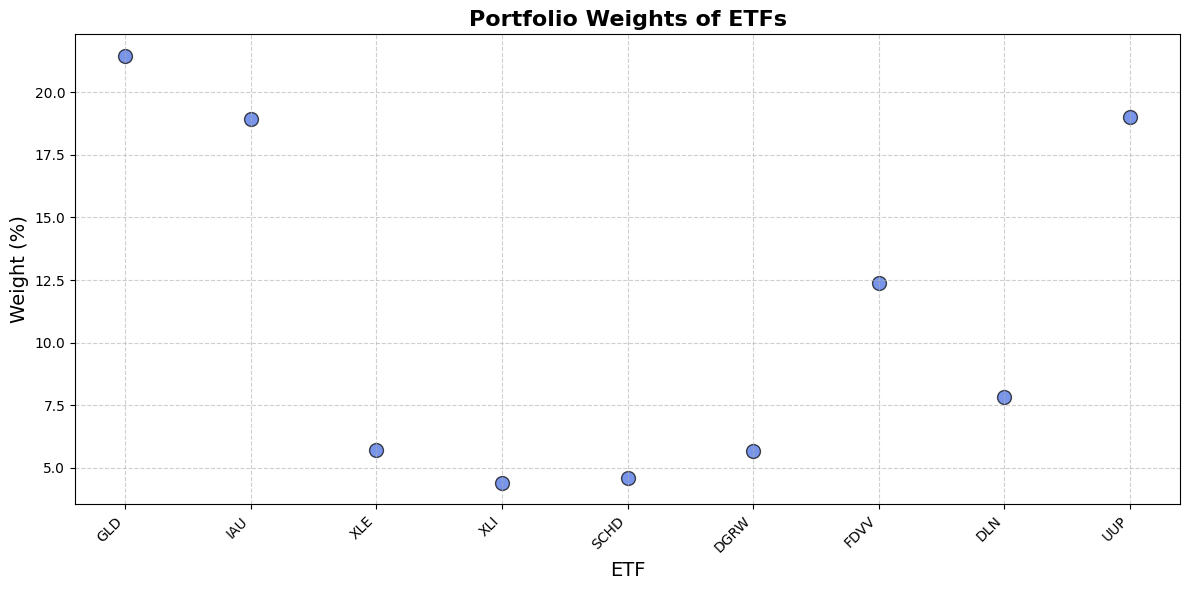

In [36]:
# Filter ETFs with significant weights
significant_etfs = etf_metrics[etf_metrics["Weight"] > 0.001]

# Scatter plot of weights
plt.figure(figsize=(12, 6))
plt.scatter(significant_etfs["ETF"], significant_etfs["Weight"] * 100, color="royalblue", edgecolor="black", s=100, alpha=0.7)
plt.title("Portfolio Weights of ETFs", fontsize=16, fontweight="bold")
plt.xlabel("ETF", fontsize=14)
plt.ylabel("Weight (%)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## **Step 10: Conclusion**

An ETF portfolio has been optimized for the highest returns given risks, momentum, ESG, and diversification constraints. The major pointers include the following:
1. **Diverse Portfolio**: We ensured weights across multiple ETFs to reduce risk.
2. **Sustainability Focus**: The portfolio achieved a very high ESG score.
3. **Tailored Model**: The portfolio can be adapted to various clients' preferences by adjusting the values of the coefficients.
4. **Major Allocation**: Only the ETFs that have remarkable weights will go towards the portfolio.

Further this model can be altered by modifying constraints and weights to accommodate different investor preferences like higher risk-taking or ESG portfolio preferences.

# Credits

This project was conceptualized, developed, and implemented by **Mohamed ZOUAD**. This project thus performed with integration of theoretical knowledge through practical applications on Python programming, focused on ETFs and multi-objective optimization.

The key contributions of the project include:
- Data extraction and processing via the `yfinance` library.
- Calculation and normalization of key financial metrics such as return, risk, momentum, ESG scores, and diversification indices.
• Designed a strong optimization model that allows constraints and objective functions to be tuned according to various client preferences. The work will involve end-to-end implementation: from data gathering through optimization, visualization, and reporting.
I could have resolved the problem without the use of scipy library by implementing gradient descent algorithm, although it would give less performant results.

For any questions or potential collaboration, please engage with me at **mohamed.zouad@dauphine.eu**.